In [146]:
meteorites_full <- read.csv(file='data/results/full_dataset.csv')

meteorites_full <- meteorites_full[, c(2,4,7,8,6,10,9,5)]
colnames(meteorites_full) <- c('Name',
                               'Valid',
                          'Fell_or_Found',
                          'Year',
                          'Mass',
                          'longitude',
                          'latitude',
                          'recclass')

In [156]:
unique(meteorites_full$Valid)

[1] Valid  Relict
Levels: Relict Valid

In [149]:
#App.R

## SETUP

library(shiny)
library(leaflet)
library(ggplot2)
library(dplyr)
library(tidyr)
library(reshape2)

library(dygraphs)
library(TTR)
library(rvest)
library(xts)

options(scipen=999)

#Data Import

#All Meteorites
meteorites <- read.csv(file='data/results/meteorites_lc.csv')
meteorites <- meteorites[, c(2:14)]
colnames(meteorites) <- c('Name',
                          'Fell_or_Found',
                          'Year',
                          'Mass',
                          'longitude',
                          'latitude',
                          'Land_Cover',
                          'Chondrite',
                          'Type',
                          'Level_3', 
                          'Level_4', 
                          'Group',
                          'recclass')

#Prob Density Function Land Cover
pdf <- read.csv(file = 'data/results/pdf.csv')
pdfmelt<-melt(pdf,id="x_axis")

LC_names  <- list("Oceans/Water",
                  "Cultivated Land",
                  "Pasture/Land for Grazing",
                  "Tundra",
                  "Wooded Tundra",
                  "Boreal Forest",
                  "Cool Conifer Forest",
                  "Temperate Mixed Forest",
                  "Temperate Decidious Forest",
                  "Grassland/Steppe",
                  "Hot Desert",
                  "Savanna",
                  "Tropical Woodland",
                  "Tropical Forest")

LC_values  <- list("water_pdf",
                   "cultivated_pdf",
                   "pasture_pdf",
                   "tundra_pdf",
                   "wooded_tundra_pdf",
                   "boreal_forest_pdf",
                   "conifer_forest_pdf",
                   "temperate_mixed_forest_pdf",
                   "temperate_decidous_forest_pdf",
                   "grasssland_pdf",
                   "desert_pdf",
                   "savanna_pdf",
                   "tropical_wooded_pdf",
                   "tropical_forest_pdf")

LC_names2  <- list("Boreal Forest",
                   "Cool Conifer Forest",
                   "Cultivated Land",
                   "Grassland/Steppe",
                   "Hot Desert",
                   "Oceans/Water",
                   "Pasture/Land used for Grazing",
                   "Savanna",
                   "Scrubland",
                   "Temperate Decidious Forest",
                   "Temperate Mixed Forest",
                   "Tropical Forest",
                   "Tropical Woodland",
                   "Tundra", 
                   "Warm Mixed Forest",
                   "Wooded Tundra")

#Timeline
falls <- subset(meteorites, Fell_or_Found == 'Fell')
worldpop <- read.csv("data/worldpop/worldpop.csv")

worldpop <- worldpop %>% rename(pop = World.Population.over.12000.years..various.sources..2019..,
                    year = Year)

avg_worldpop <- worldpop %>% group_by(year) %>% summarize(avg=mean(pop))
avg_worldpop <- as.data.frame(avg_worldpop)
avg_worldpop <- avg_worldpop[avg_worldpop$year >= 800 & avg_worldpop$year <= 2013,]
fall_count <- count(falls, vars = Year)
fall_count$decade <- floor(fall_count$vars/10)*10

falls_decade <- aggregate(fall_count$n, by=list(Category=fall_count$decade), FUN=sum)

for (i in 1:nrow(falls_decade)){
    x <- falls_decade$Category[i]
    w <- avg_worldpop$year

    closestVal = w[which.min(abs(w-x))]
    pop <- avg_worldpop[avg_worldpop$year == closestVal,]$avg

    falls_decade$pop[i] <- pop      
}

falls_decade <- falls_decade %>% rename(
    decade = Category,
    meteorite_falls = x,
    population = pop
    )

falls_decade$falls_per_1M <- falls_decade$meteorite_falls/(falls_decade$population/1000000)

falls_decade <- falls_decade[-c(44), ] 

#Falls and Finds Gridsquares
gsfellfound <- read.csv("data/results/gridsquarefellfound.csv")

#Correlation
meteorites_corr <- read.csv(file='data/results/all.csv')
meteorites_corr <-subset(meteorites_corr, select=-c(1,2,3,5,9,10,11,12,13,15))

corrlist <- list( "Mass"       = "mass",
                  "Year"       = "year",
                  "Latitude"   = "latitude",
                  "Longitude"  = "longitude",
                  "Land Cover Type" = "lc_sample")

#KModes
kmodes <- read.csv(file='data/results/meteorites_clustered.csv')
kmodes <-subset(kmodes, select=-c(1))

#Bonus
meteorites_full <- read.csv(file='data/results/full_dataset.csv')
meteorites_full <- meteorites_full[, c(2,4,7,8,6,10,9,5)]
colnames(meteorites_full) <- c('Name',
                               'Valid',
                               'Fell_or_Found',
                               'Year',
                               'Mass',
                               'longitude',
                               'latitude',
                               'recclass')


#UI

ui <- fluidPage(
    
    titlePanel("Meteorite Data Analysis"),
    
    fluidRow(
          tabsetPanel(
             tabPanel("About",
                        sidebarLayout(
                            sidebarPanel(
                               h1("Meteorite Data Analysis"),
                               h2("Visualizations by Matthew Younce"),
                               h3("PSDS Capstone")),
                            mainPanel(
                               p(),
                                p("This analysis has been performed on a dataset of meteorites from the Meteoritical Society via NASA."),
                               div("Here is a brief description of what you will find in each tab."),
                               hr(),
                               h4("Tab 1: About"),
                               div("Me telling you this."),   
                               h4("Tab 2: Meteorite Data"),
                               div("This tab shows a map and table of the meteorite data after data scrubbing was complete."),
                               h4("Tab 3: KModes Clustering"),
                               div("This is the results of an unsupervised clustering.  KModes clustering is similar to KMeans clustering, except it is for categorical data."),
                               h4("Tab 4: Land Cover PDFs"),
                               div("This shows how likely a particular mass of meteorite is for a given land cover type. If the peak is more to the left, its more likely a meteorite in that land cover type will be less massive."),
                               h4("Tab 5: Falls over Time"),
                               div("This is an attempt to see if there is any change in the rate of meteorites observed falling.  While the number has increased recently, this may be due to better record keeping rather than anything else."),
                               h4("Tab 6: Falls vs. Finds"),
                               div("This shows whether a 1°x1° grid square has seen a fall event, a find, or both."),
                               h4("Tab 7: Correlation Tester"),
                               div("This allows a comparison of numeric variables in the dataset."),
                               h4("Tab 8: Full Dataset"),
                               div("This is similar to Tab 2, except this is the full dataset from NASA without any data scrubbing.")
                               ))),
              tabPanel("Meteorite Data",
                       sidebarLayout(
                          sidebarPanel(
                              sliderInput("yearslider",
                                          label = "Year",
                                          min = 800, 
                                          max = 2021,
                                          step = 5,
                                          value = c(800,2021),
                                          sep=""),
                              sliderInput("massslider",
                                          label = "Mass (Kg)",
                                          min = 0, 
                                          max = 65000,
                                          value = c(0,65000)),
                              checkboxGroupInput(inputId = "fellfoundcheckbox",
                                                 label = "Fall or Find:",
                                                 inline = TRUE,
                                                 selected = c("Fell", "Found"),
                                                 choiceNames = c("Observed Falling","Found later"),
                                                 choiceValues = c("Fell", "Found")),
                              checkboxGroupInput(inputId = "typecheckbox",
                                                 label = "Type of Meteorite:",
                                                 inline = TRUE,
                                                 selected = c("Stony","Stony-Iron","Iron","-"),
                                                 choiceNames = c("Stony","Stony-Iron","Iron","Unknown"),
                                                 choiceValues= c("Stony","Stony-Iron","Iron","-")),
                              checkboxGroupInput(inputId = "chondritecheckbox",
                                                 label = "Chondrite or Achondrite:",
                                                 inline = TRUE,
                                                 selected = c("Chondrite","Achondrite","-"),
                                                 choiceNames = c("Chondrite","Achondrite","Unknown"),
                                                 choiceValues = c("Chondrite","Achondrite","-")),
                              checkboxGroupInput(inputId = "meteoriteLCcheckbox",
                                                 label = "Land Cover at impact site:",
                                                 selected = LC_names2,
                                                 choiceNames = LC_names2,
                                                 choiceValues = LC_names2)),
                       mainPanel(
                           leafletOutput("meteoritemap"),
                           dataTableOutput('meteorite_table')))),
              tabPanel("KModes Clustering",
                      sidebarLayout(
                          sidebarPanel(
                              radioButtons(
                                  inputId="KMradio",
                                  label="Choose cluster to display",
                                  selected = NULL,
                                  inline = TRUE,
                                  choices = c(0:6))),
                          mainPanel(leafletOutput("kmodesmap"),
                                    dataTableOutput("kmodestable")))),
              tabPanel("Land Cover PDFs",
                       sidebarLayout(
                           sidebarPanel(checkboxGroupInput(inputId = "pdfcheckbox",
                                                       label = "Choose Land Covers to display",
                                                       selected = LC_values,
                                                       choiceNames = LC_names,
                                                       choiceValues = LC_values)),
                           mainPanel(plotOutput("pdfplot")))),
               tabPanel("Falls over Time",
                        sidebarLayout(
                            sidebarPanel(
                                checkboxInput(inputId = "norm_check", label = "Normalize?", value = FALSE)),
                            mainPanel(dygraphOutput("timelineplot"),
                                      plotOutput("timelinecorrplot")))),
                tabPanel("Falls vs. Finds",
                        sidebarLayout(
                            sidebarPanel(
                                checkboxGroupInput(inputId = "gridsquares",
                                                 label = "Display 1° x 1° squares with:",
                                                 inline = TRUE,
                                                 selected = c("fall", "find", "both"),
                                                 choiceNames = c("Falls Only (Red)", "Finds Only(Blue)", "Both (Green)"),
                                                 choiceValues = c("fall", "find", "both"))),
                         mainPanel(leafletOutput("gsmap"),
                                  div("Finds Only: 1063, Falls Only: 712, Both: 181")))),
              tabPanel("Correlation Tester",
                       fluidRow(
                           column(6,wellPanel(
                               selectInput("corrvariable1",
                                           "Select variable #1:",
                                           c(list("Variables" = corrlist)),
                                           selected = "mass"))),
                 column(6,wellPanel(
                               selectInput("corrvariable2",
                                           "Select variable #2:",
                                           c(list("Variables" = corrlist)),
                                           selected = "lc_sample"))),
                 plotOutput("plot_chooseyourown"))),
              tabPanel("Full Dataset",
                       sidebarLayout(
                          sidebarPanel(
                              sliderInput("bonusyearslider",
                                          label = "Year",
                                          min = 800, 
                                          max = 2021,
                                          step = 5,
                                          value = c(800,2021),
                                          sep=""),
                              sliderInput("bonusmassslider",
                                          label = "Mass (Kg)",
                                          min = 0, 
                                          max = 65000,
                                          value = c(0,65000)),
                              checkboxGroupInput(inputId = "bonusvalid",
                                                 label = "Valid or Relict:",
                                                 inline = TRUE,
                                                 selected = c("Valid", "Relict"),
                                                 choiceNames = c("Valid","Relict"),
                                                 choiceValues = c("Valid", "Relict")),
                              checkboxGroupInput(inputId = "bonusfellfoundcheckbox",
                                                 label = "Fall or Find:",
                                                 inline = TRUE,
                                                 selected = c("Fell", "Found"),
                                                 choiceNames = c("Observed Falling","Found later"),
                                                 choiceValues = c("Fell", "Found"))),
                       mainPanel(
                           leafletOutput("bonusmeteoritemap"),
                           dataTableOutput('bonusmeteorite_table'))))
          )
    )
)

##SERVER
server <- function(input, output, session) {
    
    reac <- reactiveValues(yearslider = c(800,2021), 
                       fellfoundcheckbox = c("Fell", "Found"), 
                       typecheckbox = c("Stony","Stony-Iron","Iron","-"),
                       chondritecheckbox = c("Chondrite","Achondrite","-"),
                       massslider = c(0,65000000),
                       meteoriteLCcheckbox = LC_names2,
                       corrvariable1 = "mass",
                       corrvariable2 = "lc_sample")
                       bonusyearslider = c(800,2021)
                       reac$bonusmassslider = c(0,65000)
                       bonusfellfoundcheckbox = c("Fell", "Found")
                       bonusvalid = c("Valid","Relict")
    
    observeEvent (input$yearslider, {
        reac$yearslider = input$yearslider
    })
    observeEvent (input$fellfoundcheckbox, {
        reac$fellfoundcheckbox = input$fellfoundcheckbox
    })
    observeEvent (input$typecheckbox, {
        reac$typecheckbox = input$typecheckbox
    })
    observeEvent (input$chondritecheckbox, {
        reac$chondritecheckbox = input$chondritecheckbox
    })
    observeEvent (input$massslider, {
        reac$massslider = input$massslider *1000
    })
    observeEvent (input$meteoriteLCcheckbox, {
        reac$meteoriteLCcheckbox = input$meteoriteLCcheckbox
    })

    observeEvent (input$corrvariable1, {
        reac$corrvariable1 = input$corrvariable1
    })
    observeEvent (input$corrvariable2, {
        reac$corrvariable2 = input$corrvariable2
    })
    
    
    observeEvent (input$bonusyearslider, {
        reac$bonusyearslider = input$bonusyearslider
    })
    observeEvent (input$bonusmassslider, {
        reac$bonusmassslider = input$bonusmassslider *1000
    })
    observeEvent (input$bonusfellfoundcheckbox, {
        reac$bonusfellfoundcheckbox = input$bonusfellfoundcheckbox
    })
    observeEvent (input$bonusvalid, {
        reac$bonusvalid = input$bonusvalid
    })


    
    
    
    
    
    
    
    output$pdfplot = renderPlot({
        pdf_plot <- subset(pdfmelt, variable %in% input$pdfcheckbox)
        p <- ggplot()
        p <- p + geom_line(data = pdf_plot, aes(x = x_axis, y = value, color=variable, group=variable))
        p <- p + ggtitle("Probability Density Function of Mass by Land Cover Type")
        p <- p + labs(x = "Meteorite Mass (g)", y= NULL)
        p
    })
    
    output$meteorite_table = renderDataTable({
            map_meteorites <- meteorites
            map_meteorites <- subset(map_meteorites, Fell_or_Found %in% reac$fellfoundcheckbox)
            map_meteorites <- map_meteorites[map_meteorites$Year >= reac$yearslider[1] & map_meteorites$Year <= reac$yearslider[2],]
            map_meteorites <- map_meteorites[map_meteorites$Mass >= reac$massslider[1] & map_meteorites$Mass <= reac$massslider[2],]
            map_meteorites <- subset(map_meteorites, Type %in% reac$typecheckbox)
            map_meteorites <- subset(map_meteorites, Chondrite %in% reac$chondritecheckbox)
            map_meteorites <- subset(map_meteorites, Land_Cover %in% reac$meteoriteLCcheckbox)

            map_meteorites})

    output$meteoritemap = renderLeaflet({
            map_meteorites <- meteorites
            map_meteorites <- subset(map_meteorites, Fell_or_Found %in% reac$fellfoundcheckbox)
            map_meteorites <- map_meteorites[map_meteorites$Year >= reac$yearslider[1] & map_meteorites$Year <= reac$yearslider[2],]
            map_meteorites <- map_meteorites[map_meteorites$Mass >= reac$massslider[1] & map_meteorites$Mass <= reac$massslider[2],]
            map_meteorites <- subset(map_meteorites, Type %in% reac$typecheckbox)
            map_meteorites <- subset(map_meteorites, Chondrite %in% reac$chondritecheckbox)
            map_meteorites <- subset(map_meteorites, Land_Cover %in% reac$meteoriteLCcheckbox)

            map <- leaflet(map_meteorites) %>% addTiles() %>% addMarkers(label = ~Name, clusterOptions = markerClusterOptions())
            map
    })
    
    output$bonusmeteorite_table = renderDataTable({
            map_meteorites <- meteorites_full
            map_meteorites <- map_meteorites[map_meteorites$Year >= reac$bonusyearslider[1] & map_meteorites$Year <= reac$bonusyearslider[2],]
            map_meteorites <- map_meteorites[map_meteorites$Mass >= reac$bonusmassslider[1] & map_meteorites$Mass <= reac$bonusmassslider[2],]
            map_meteorites <- subset(map_meteorites, Fell_or_Found %in% reac$bonusfellfoundcheckbox)
            map_meteorites <- subset(map_meteorites, Valid %in% reac$bonusvalid)

            map_meteorites})

    output$bonusmeteoritemap = renderLeaflet({
            map_meteorites <- meteorites_full
            map_meteorites <- map_meteorites[map_meteorites$Year >= reac$bonusyearslider[1] & map_meteorites$Year <= reac$bonusyearslider[2],]
            map_meteorites <- map_meteorites[map_meteorites$Mass >= reac$bonusmassslider[1] & map_meteorites$Mass <= reac$bonusmassslider[2],]
            map_meteorites <- subset(map_meteorites, Fell_or_Found %in% reac$bonusfellfoundcheckbox)
            map_meteorites <- subset(map_meteorites, Valid %in% reac$bonusvalid)

            map <- leaflet(map_meteorites) %>% addTiles() %>% addMarkers(label = ~Name, clusterOptions = markerClusterOptions())
            map
    })
    
    output$timelineplot <- renderDygraph({

      if (input$norm_check == FALSE) {
          falls_decade_plot <- subset(falls_decade, select = -c(falls_per_1M))
       
          dygraph(falls_decade_plot, main="Meteorite Falls", height=400) %>%
          dyOptions(drawGapEdgePoints = TRUE,fillGraph = TRUE,drawGrid=FALSE) %>%
          dyLegend(width = 400) %>%
          dySeries("meteorite_falls", label = "Falls") %>%
          dyAxis("y", label = "Meteorite Falls")  %>%
          dySeries("population", axis = "y2", label = "Population") %>%
          dyAxis("y2", label = "Population", independentTicks =TRUE)  %>%
          dyRangeSelector(height = 75)

          } else {
          falls_decade_plot <- subset(falls_decade, select = -c(meteorite_falls))
          
          dygraph(falls_decade_plot, main="Meteorite Falls (Normalized per 1 Million Population)", height=400) %>%
          dyOptions(drawGapEdgePoints = TRUE,fillGraph = TRUE,drawGrid=FALSE) %>%
          dyLegend(width = 400) %>%
          dySeries("falls_per_1M", label = "Normalized Falls") %>%
          dyAxis("y", label = "Meteorite Falls")  %>%
          dySeries("population", axis = "y2", label = "Population") %>%
          dyAxis("y2", label = "Population", independentTicks =TRUE)  %>%
          dyRangeSelector(height = 75)

        }
        })

    output$timelinecorrplot = renderPlot({

          if (input$norm_check == FALSE) {
          falls_decade_plot <- subset(falls_decade, select = -c(falls_per_1M))          
          corrplot <- ggplot(falls_decade_plot, aes(x=population, y=meteorite_falls)) + geom_point()
          corrplot <- corrplot + geom_smooth(method="auto", se=TRUE, fullrange=FALSE, level=0.95)
          
          corrplot
          } else {
          falls_decade_plot <- subset(falls_decade, select = -c(meteorite_falls))         



          corrplot <- ggplot(falls_decade_plot, aes(x=population, y=falls_per_1M)) + geom_point()
          corrplot <- corrplot + geom_smooth(method="auto", se=TRUE, fullrange=FALSE, level=0.95)
          
          corrplot}
        })
    
        output$kmodesmap = renderLeaflet({

            kmodes_filtered <- subset(kmodes, Cluster == input$KMradio)

            map_km <- leaflet(kmodes_filtered) %>% addTiles() %>% addMarkers(clusterOptions = markerClusterOptions())
            map_km
        })
    
    
        output$kmodestable =  renderDataTable({
            kmodes_filtered <- subset(kmodes, Cluster == input$KMradio)
            kmodes_filtered
        })
    
    
    output$gsmap = renderLeaflet({
        gsplot <- subset(gsfellfound, fallorfind %in% input$gridsquares)
        gsplot <- gsplot[-c(1) ] 
        colnames(gsplot) <- c("latitude", "longitude", "score", "group")

        getColor <- function(gsplot) {
        sapply(gsplot$score, function(score) {
            if(score == -1) {
                "blue"
            } else if(score == 1) {
                "red"
            } else {
                "green"
            }})}
        icons <- awesomeIcons(
            icon = 'ios-close',
            iconColor = 'black',
            library = 'ion',
            markerColor = getColor(gsplot))
            
        map2 <- leaflet(gsplot) %>% addTiles() %>% addAwesomeMarkers(~longitude, ~latitude, icon=icons)
            map2
    })
    
    output$plot_chooseyourown = renderPlot({
        
        corr_final <- meteorites_corr %>% select(reac$corrvariable1, reac$corrvariable2)
        
        p <- ggplot(corr_final, aes(x=corr_final[[1]], y=corr_final[[2]]))
        p <- p + geom_point(color="firebrick")
        p <- p + geom_smooth(method = lm, se = FALSE, color="blue") 
        p <- p + ggtitle(paste0(reac$corrvariable1," vs. ", reac$corrvariable2,"\nCorrelation Coeff. = ",cor(corr_final)[1,2]))
        p <- p + labs(x = reac$corrvariable1, y= reac$corrvariable2)
        p
    
    })
    
}

## Run App

shinyApp(ui = ui, server = server)

In [174]:
#DEPLOY TO SHINY SERVER
dir <- getwd() #This gets the current Working Directory
course <- "PSDS4900" #This is to specify the course path for the shiny server
folder <- "dashboard" #This specifies the folder name to copy

system(sprintf("/usr/local/bin/shiny_deploy %s %s %s", course, dir,folder), 
       intern = TRUE,
       ignore.stdout = FALSE, 
       ignore.stderr = FALSE,
       wait = TRUE, 
       input = NULL)

[1] "sending incremental file list"                                                                                       
[2] "dashboard/"                                                                                                          
[3] "dashboard/app.R"                                                                                                     
[4] "\r         24,463 100%    0.00kB/s    0:00:00  \r         24,463 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=133/135)"
[5] ""                                                                                                                    
[6] "sent 28,509 bytes  received 56 bytes  57,130.00 bytes/sec"                                                           
[7] "total size is 88,102,331  speedup is 3,084.28"

In [116]:
url <- cat("https://shiny.sgn.missouri.edu/students/ymw.0780/",course,"/",folder,"\n\n",sep="")
print(url)

https://shiny.sgn.missouri.edu/students/ymw.0780/PSDS4900/dashboard

NULL


In [166]:
meteorites[meteorites$Mass == 60000000,]

,id,Name,Fell_or_Found,Year,Mass,longitude,latitude,Land_Cover,Chondrite,Type,Level_3,Level_4,Group,recclass
4012,11890,Hoba,Found,1920,60000000,17.91667,-19.58333,Pasture/Land used for Grazing,Achondrite,Iron,Magmatic,Siderite,Iron IVB,"Iron, IVB"


In [6]:
meteorites <- read.csv(file='data/results/meteorites_lc.csv')
meteorites <- meteorites[, c(2,3,7,8,6,10,9,18,13:16,12,5)]
colnames(meteorites) <- c('id','Meteorite Name','Fell_or_Found','Year', 'Mass (g)', 'Longitude', 'Latitude', 'Land Cover', 'Chondrite', 'Type', 'Level 3', 'Level 4', 'Group','recclass')

meteorites

id,Meteorite Name,Fell_or_Found,Year,Mass (g),Longitude,Latitude,Land Cover,Chondrite,Type,Level 3,Level 4,Group,recclass
1,Aachen,Fell,1880,21.0,6.08333,50.77500,Temperate Decidious Forest,Chondrite,Stony,Ordinary,L,L,L5
2,Aarhus,Fell,1951,720.0,10.23333,56.18333,Cultivated Land,Chondrite,Stony,Ordinary,H,H,H6
4,Abajo,Found,1982,331.0,-105.41667,26.80000,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,H,H,H5
5,Abbott,Found,1951,21100.0,-104.28333,36.30000,Grassland/Steppe,Chondrite,Stony,Ordinary,H,H,H3-6
6,Abee,Fell,1952,107000.0,-113.00000,54.21667,Cultivated Land,Chondrite,Stony,Enstatite,EH-EL,EH,EH4
7,Abernathy,Found,1941,2914.0,-101.80000,33.85000,Cultivated Land,Chondrite,Stony,Ordinary,L,L,L6
8,Abo,Found,1840,1.2,22.30000,60.43333,Cultivated Land,Chondrite,Stony,Ordinary,H,H,H
9,Abu Moharek,Found,1997,4500.0,29.83583,27.23944,Temperate Decidious Forest,Chondrite,Stony,Ordinary,H,H,H4
10,Acapulco,Fell,1976,1914.0,-99.90000,16.88333,Oceans/Water,Achondrite,Stony,Primitive,-,Acapulcoite,Acapulcoite
11,Acfer 001,Found,1989,6700.0,3.61667,27.50000,Hot Desert,Chondrite,Stony,Ordinary,L,L,L6


In [7]:
pdf <- read.csv(file = 'data/results/pdf.csv')
pdf

X,x_axis,water_pdf,cultivated_pdf,pasture_pdf,tundra_pdf,wooded_tundra_pdf,boreal_forest_pdf,conifer_forest_pdf,temperate_mixed_forest_pdf,temperate_decidous_forest_pdf,grasssland_pdf,desert_pdf,savanna_pdf,tropical_wooded_pdf,tropical_forest_pdf
0,0,8.336332e-06,6.120329e-07,1.951613e-07,4.926540e-06,1.032228e-05,3.046063e-06,7.760554e-08,3.048207e-06,5.896893e-06,1.750323e-07,2.347376e-07,5.564762e-07,2.474312e-05,3.502080e-05
1,1000,8.399062e-06,6.121160e-07,1.951685e-07,4.972965e-06,1.246673e-05,3.055230e-06,7.760904e-08,3.056104e-06,5.903189e-06,1.750406e-07,2.347491e-07,5.565957e-07,2.862377e-05,3.729027e-05
2,2000,8.458092e-06,6.121978e-07,1.951757e-07,5.018688e-06,1.486394e-05,3.064219e-06,7.761254e-08,3.063822e-06,5.908192e-06,1.750489e-07,2.347606e-07,5.567141e-07,3.257584e-05,3.925004e-05
3,3000,8.513339e-06,6.122780e-07,1.951828e-07,5.063684e-06,1.749522e-05,3.073029e-06,7.761603e-08,3.071360e-06,5.911899e-06,1.750571e-07,2.347720e-07,5.568315e-07,3.647208e-05,4.083756e-05
4,4000,8.564721e-06,6.123569e-07,1.951899e-07,5.107923e-06,2.032869e-05,3.081659e-06,7.761952e-08,3.078717e-06,5.914308e-06,1.750653e-07,2.347833e-07,5.569477e-07,4.017184e-05,4.200050e-05
5,5000,8.612167e-06,6.124343e-07,1.951969e-07,5.151381e-06,2.331866e-05,3.090105e-06,7.762300e-08,3.085891e-06,5.915418e-06,1.750735e-07,2.347945e-07,5.570629e-07,4.352906e-05,4.269965e-05
6,6000,8.655606e-06,6.125102e-07,1.952039e-07,5.194029e-06,2.640597e-05,3.098367e-06,7.762649e-08,3.092882e-06,5.915227e-06,1.750817e-07,2.348056e-07,5.571770e-07,4.640162e-05,4.291105e-05
7,7000,8.694975e-06,6.125847e-07,1.952108e-07,5.235843e-06,2.951922e-05,3.106444e-06,7.762996e-08,3.099687e-06,5.913735e-06,1.750898e-07,2.348167e-07,5.572900e-07,4.866125e-05,4.262743e-05
8,8000,8.730218e-06,6.126578e-07,1.952177e-07,5.276796e-06,3.257707e-05,3.114333e-06,7.763344e-08,3.106305e-06,5.910944e-06,1.750979e-07,2.348277e-07,5.574019e-07,5.020300e-05,4.185855e-05
9,9000,8.761282e-06,6.127294e-07,1.952246e-07,5.316863e-06,3.549143e-05,3.122033e-06,7.763692e-08,3.112736e-06,5.906856e-06,1.751059e-07,2.348386e-07,5.575127e-07,5.095330e-05,4.063070e-05


In [ ]:
library(reshape2)
pdfmelt<-melt(pdf,id="x_axis")
print(pdfmelt)

In [ ]:
library(ggplot2)

pdfcheckbox <- list("tropical_forest_pdf","water_pdf","tundra_pdf")

pdf_plot <- subset(pdfmelt, variable %in% pdfcheckbox)

p <- ggplot()
p <- p + geom_line(data = pdf_plot, aes(x = x_axis, y = value, color=variable, group=variable))
p <- p + ggtitle(paste0("Probability Density Function of Mass by Land Cover Type"))
p <- p + labs(x = "Meteorite Mass (g)", y= NULL)
p

pdf_plot

In [9]:
fellfoundcheckbox = c('Fell')
yearslider = c(500,1500)





map_meteorites <- meteorites
map_meteorites <- subset(map_meteorites, Fell_or_Found %in% fellfoundcheckbox)
map_meteorites <- map_meteorites[map_meteorites$Year >= yearslider[1] & map_meteorites$Year <= yearslider[2],]

map_meteorites

,id,Meteorite Name,Fell_or_Found,Year,Mass (g),Longitude,Latitude,Land Cover,Chondrite,Type,Level 3,Level 4,Group,recclass
3281,7823,Elbogen,Fell,1399,107000.0,12.73333,50.18333,Temperate Mixed Forest,Achondrite,Iron,Magmatic,Siderite,Iron IID,"Iron, IID"
3310,10039,Ensisheim,Fell,1491,127000.0,7.35000,47.86667,Temperate Decidious Forest,Chondrite,Stony,Ordinary,LL,LL,LL6
4974,16914,Narni,Fell,920,367.0,12.51667,42.51667,Temperate Decidious Forest,-,Stony,-,-,Stony,Stone-uncl
5038,16988,Nogata,Fell,860,472.0,130.75000,33.72500,Temperate Decidious Forest,Chondrite,Stony,Ordinary,L,L,L6
5614,22614,Rivolta de Bassi,Fell,1490,103.3,9.51667,45.48333,Cultivated Land,-,Stony,-,-,Stony,Stone-uncl
6699,24146,Valdinoce,Fell,1495,367.0,12.10000,44.06667,Pasture/Land used for Grazing,-,Stony,-,-,Stony,Stone-uncl


In [83]:
falls_decade

decade,meteorite_falls,population,falls_per_1M
860,1,259164965,0.003858546
920,1,259164965,0.003858546
1390,1,370909931,0.002696072
1490,3,451668483,0.006642040
1510,1,451668483,0.002214013
1580,1,538844605,0.001855823
1620,3,538844605,0.005567468
1630,3,538844605,0.005567468
1640,1,538844605,0.001855823
1650,1,538844605,0.001855823


In [134]:
meteorites_dummy <- read.csv(file='data/results/meteorites_dummy.csv')
corr_final <- meteorites_dummy %>% select("mass", "lc_sample")
head(corr_final)

mass,lc_sample
21,11
720,1
331,2
21100,13
107000,1
2914,1


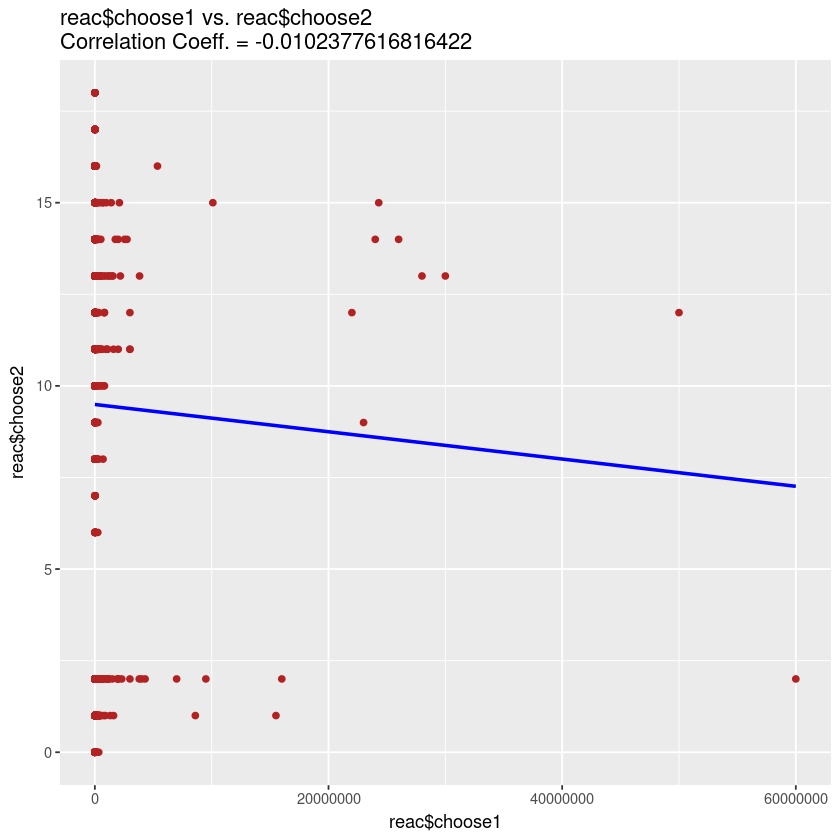

In [135]:
p <- ggplot(corr_final, aes(x=corr_final[[1]], y=corr_final[[2]]))
p <- p + geom_point(color="firebrick")
p <- p + geom_smooth(method = lm, se = FALSE, color="blue") 
p <- p + ggtitle(paste0("reac$choose1"," vs. ", "reac$choose2","\nCorrelation Coeff. = ",cor(corr_final)[1,2]))
p <- p + labs(x = "reac$choose1", y= "reac$choose2")
p
    

mass,year,latitude,longitude,lc_sample
21.0,1880,50.77500,6.08333,11
720.0,1951,56.18333,10.23333,1
331.0,1982,26.80000,-105.41667,2
21100.0,1951,36.30000,-104.28333,13
107000.0,1952,54.21667,-113.00000,1
2914.0,1941,33.85000,-101.80000,1
1.2,1840,60.43333,22.30000,1
4500.0,1997,27.23944,29.83583,11
1914.0,1976,16.88333,-99.90000,0
6700.0,1989,27.50000,3.61667,14


In [174]:
colnames(meteorites)

[1] "id"            "Name"          "Fell_or_Found" "Year"         
 [5] "Mass"          "longitude"     "latitude"      "Land_Cover"   
 [9] "Chondrite"     "Type"          "Level_3"       "Level_4"      
[13] "Group"         "recclass"

In [184]:
unique(meteorites$Group)

[1] L                   H                   EH                 
 [4] Acapulcoite         LL                  CR                 
 [7] Mesosiderite        CV                  Chondrite          
[10] CH                  CO                  Rumuruti           
[13] Iron IAB            Ureilite            EH or EL           
[16] CM                  Eucrite             EL                 
[19] Main Group          Iron IIIAB          Iron IIAB          
[22] Diogenite           Unknown             Iron IVA           
[25] CI                  Iron                Iron IID           
[28] Stony               Angrite             Iron IC            
[31] Iron IIE            Iron IIIE           Aubrite            
[34] Iron IIG            Iron IIC            CB                 
[37] Ungrouped           Howardite           Iron IIIF          
[40] Brachinite          H,L, or LL          Lunar              
[43] CK                  Iron IVB            Chassignite        
[46] Eagle Station Group Iron IIF            Shergottite        
[49] Achondrite          Winonaite           Loderanite         
[52] Nakhilite           Kakangari          
53 Levels: Acapulcoite Achondrite Angrite Aubrite Brachinite CB CH CI CK ... Winonaite

In [2]:
kmodes <- read.csv(file='data/results/meteorites_clustered.csv')


In [3]:
kmodes

X,Cluster,mass,fell_found,year,latitude,longitude,group,chondrite,type,lc_sample
1,3,21.0,Fell,1880,50.77500,6.08333,L,Chondrite,Stony,11
2,3,720.0,Fell,1951,56.18333,10.23333,H,Chondrite,Stony,1
3,0,331.0,Found,1982,26.80000,-105.41667,H,Chondrite,Stony,2
4,0,21100.0,Found,1951,36.30000,-104.28333,H,Chondrite,Stony,13
5,3,107000.0,Fell,1952,54.21667,-113.00000,EH,Chondrite,Stony,1
6,3,2914.0,Found,1941,33.85000,-101.80000,L,Chondrite,Stony,1
7,0,1.2,Found,1840,60.43333,22.30000,H,Chondrite,Stony,1
8,0,4500.0,Found,1997,27.23944,29.83583,H,Chondrite,Stony,11
9,3,1914.0,Fell,1976,16.88333,-99.90000,Acapulcoite,Achondrite,Stony,0
10,6,6700.0,Found,1989,27.50000,3.61667,L,Chondrite,Stony,14


In [4]:
summary(kmodes)

       X           Cluster           mass          fell_found        year     
 Min.   :   1   Min.   :0.000   Min.   :       0   Fell :1079   Min.   : 860  
 1st Qu.:2470   1st Qu.:0.000   1st Qu.:      95   Found:8768   1st Qu.:1975  
 Median :4947   Median :0.000   Median :     370                Median :1998  
 Mean   :4951   Mean   :1.778   Mean   :   54383                Mean   :1979  
 3rd Qu.:7436   3rd Qu.:4.000   3rd Qu.:    2157                3rd Qu.:2002  
 Max.   :9897   Max.   :6.000   Max.   :60000000                Max.   :2013  
                                                                              
    latitude        longitude              group           chondrite   
 Min.   :-57.79   Min.   :-163.17   H         :4161   Achondrite:1486  
 1st Qu.: 19.05   1st Qu.:  -9.50   L         :3209   Chondrite :8361  
 Median : 25.53   Median :  16.39   LL        : 570                    
 Mean   : 20.48   Mean   :  12.19   Iron IIIAB: 237                    
 3rd Qu.

In [5]:
km0 <- subset(kmodes, kmodes$Cluster == 0)
km0 <- subset(km0,select=-c(1))
km1 <- subset(kmodes, kmodes$Cluster == 1)
km1 <- subset(km1,select=-c(1))
km2 <- subset(kmodes, kmodes$Cluster == 2)
km2 <- subset(km2,select=-c(1))
km3 <- subset(kmodes, kmodes$Cluster == 3)
km3 <- subset(km3,select=-c(1))
km4 <- subset(kmodes, kmodes$Cluster == 4)
km4 <- subset(km4,select=-c(1))
km5 <- subset(kmodes, kmodes$Cluster == 5)
km5 <- subset(km5,select=-c(1))
km6 <- subset(kmodes, kmodes$Cluster == 6)
km6 <- subset(km6,select=-c(1))


In [6]:
summary(km0)

    Cluster       mass         fell_found        year         latitude     
 Min.   :0   Min.   :      0   Fell : 297   Min.   :1491   Min.   :-44.82  
 1st Qu.:0   1st Qu.:     67   Found:4718   1st Qu.:1995   1st Qu.: 18.91  
 Median :0   Median :    238                Median :2001   Median : 21.04  
 Mean   :0   Mean   :   5562                Mean   :1992   Mean   : 19.67  
 3rd Qu.:0   3rd Qu.:    999                3rd Qu.:2004   3rd Qu.: 28.46  
 Max.   :0   Max.   :4000000                Max.   :2013   Max.   : 66.00  
                                                                           
   longitude             group           chondrite            type     
 Min.   :-157.7833   H      :3737   Achondrite: 321   Iron      :   0  
 1st Qu.:   0.1451   LL     : 374   Chondrite :4694   Stony     :4969  
 Median :  16.4877   L      : 318                     Stony-Iron:  46  
 Mean   :  14.2021   Eucrite:  74                                      
 3rd Qu.:  54.8769   CO     :  6

In [21]:
library(tidyverse)

kmodes2<- kmodes

kmodes2 <- kmodes %>% 
  group_by(Cluster) %>% 
  summarize(min_mass = min(mass),
            max_mass = max(mass),
            min_year=min(year),
            max_year=max(year),
            min_long=min(longitude),
            max_long=max(longitude),
            min_lat=min(latitude),
            max_lat=max(latitude))
kmodes2
            
kmodes2$stony <- count(type)


kmodes3<- kmodes %>%
  group_by(Cluster) %>% 
  count(type)

kmodes3

kmodes4 <- kmodes %>%
  group_by(Cluster) %>% 
  count(chondrite)

kmodes4

total <- merge(kmodes4,kmodes3,by="Cluster")

total

Cluster,min_mass,max_mass,min_year,max_year,min_long,max_long,min_lat,max_lat
0,0.10,4000000,1491,2013,-157.7833,175.7303,-44.81667,66.00000
1,0.15,60000000,1399,2009,-163.1667,178.0833,-57.78667,66.40000
2,0.54,77000,2005,2005,-117.6662,126.4344,-40.53333,54.24028
3,0.10,2000000,860,2012,-157.8667,174.4000,-44.11667,66.34833
4,2.10,1750000,1838,1999,-118.5000,168.4000,-46.31667,63.30000
5,0.26,1003000,1936,2012,-134.2014,142.6000,-41.06667,59.70444
6,3.00,105000,1901,1989,-112.4089,142.0167,-30.88333,39.82467


Cluster,type,n
0,Stony,4969
0,Stony-Iron,46
1,Iron,929
1,Stony,35
1,Stony-Iron,59
2,Stony,219
2,Stony-Iron,19
3,Stony,780
3,Stony-Iron,4
4,Stony,526


Cluster,chondrite,n
0,Achondrite,321
0,Chondrite,4694
1,Achondrite,1023
2,Achondrite,30
2,Chondrite,208
3,Achondrite,53
3,Chondrite,731
4,Achondrite,1
4,Chondrite,525
5,Achondrite,50


Cluster,chondrite,n.x,type,n.y
0,Achondrite,321,Stony,4969
0,Achondrite,321,Stony-Iron,46
0,Chondrite,4694,Stony,4969
0,Chondrite,4694,Stony-Iron,46
1,Achondrite,1023,Iron,929
1,Achondrite,1023,Stony,35
1,Achondrite,1023,Stony-Iron,59
2,Achondrite,30,Stony,219
2,Achondrite,30,Stony-Iron,19
2,Chondrite,208,Stony,219


In [31]:
kmodesA <- kmodes %>% count(Cluster,type,chondrite)

In [36]:
kmodesz <- as.table(kmodes)

ERROR: Error in as.table.default(kmodes): cannot coerce to a table


In [56]:
dim(meteorites)

[1] 9826   13

In [58]:
            map_meteorites <- subset(meteorites, Fell_or_Found %in% c("Fell","Found"))
#            map_meteorites <- map_meteorites[map_meteorites$Year >= reac$yearslider[1] & map_meteorites$Year <= reac$yearslider[2],]
#            map_meteorites <- map_meteorites[map_meteorites$Mass >= reac$massslider[1] & map_meteorites$Mass <= reac$massslider[2],]
#            map_meteorites <- subset(map_meteorites, Type %in% reac$typecheckbox)
#            map_meteorites <- subset(map_meteorites, Chondrite %in% reac$chondritecheckbox)
#            map_meteorites <- subset(map_meteorites, Land_Cover %in% reac$meteoriteLCcheckbox)


In [60]:
dim(map_meteorites)

[1] 9826   13

NULL

In [105]:
meteorites[meteorites$Land_Cover == "Pasture/Land used for Grazing",]

,Name,Fell_or_Found,Year,Mass,longitude,latitude,Land_Cover,Chondrite,Type,Level_3,Level_4,Group,recclass
3,Abajo,Found,1982,331,-105.41667,26.80000,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,H,H,H5
366,Achilles,Found,1924,16000,-100.81333,39.77667,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,H,H,H5
367,Achiras,Fell,1902,780,-64.95000,-33.16667,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,L,L,L6
374,Adhi Kot,Fell,1919,4239,71.80000,32.10000,Pasture/Land used for Grazing,Chondrite,Stony,Enstatite,EH-EL,EH,EH4
384,Adzhi-Bogdo (iron),Found,1952,582000,95.41667,44.86667,Pasture/Land used for Grazing,Achondrite,Iron,Non-magmatic,Primative,Iron IAB,"Iron, IAB complex"
385,Adzhi-Bogdo (stone),Fell,1949,910,95.16667,44.83333,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,LL,LL,LL3-6
386,Agen,Fell,1814,30000,0.61667,44.21667,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,H,H,H5
389,Agua Blanca,Found,1938,49000,-66.95000,-28.91667,Pasture/Land used for Grazing,Achondrite,Iron,Magmatic,Siderite,Iron IIIAB,"Iron, IIIAB"
390,Aguada,Fell,1930,1620,-65.23333,-31.60000,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,L,L,L6
409,Aguila Blanca,Fell,1920,1440,-64.55000,-30.86667,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,L,L,L


Warning message in `[<-.factor`(`*tmp*`, list, value = "Pasture/Land used for Grazing"):
"invalid factor level, NA generated"

In [97]:
meteorites <- read.csv(file='data/results/meteorites_lc.csv',stringsAsFactors = FALSE)
meteorites <- meteorites[, c(3,7,8,6,10,9,18,13:16,12,5)]
colnames(meteorites) <- c('Name','Fell_or_Found','Year', 'Mass', 'longitude', 'latitude', 'Land_Cover', 'Chondrite', 'Type', 'Level_3', 'Level_4', 'Group','recclass')


In [101]:
unique(meteorites['Land_Cover'],)

,Land_Cover
1,Temperate Decidious Forest
2,Cultivated Land
3,Pasture/Land used for Grazing
4,Grassland/Steppe
9,Oceans/Water
10,Hot Desert
370,Scrubland
387,Boreal Forest
422,Savanna
443,Tropical Forest


In [100]:
str(meteorites$Land_Cover)


 chr [1:9826] "Temperate Decidious Forest" "Cultivated Land" ...


In [98]:
meteorites$Land_Cover<-replace(meteorites$Land_Cover, meteorites$Land_Cover=="Pasture/Land used for\nGrazing", "Pasture/Land used for Grazing")

In [99]:
head(meteorites)

Name,Fell_or_Found,Year,Mass,longitude,latitude,Land_Cover,Chondrite,Type,Level_3,Level_4,Group,recclass
Aachen,Fell,1880,21,6.08333,50.77500,Temperate Decidious Forest,Chondrite,Stony,Ordinary,L,L,L5
Aarhus,Fell,1951,720,10.23333,56.18333,Cultivated Land,Chondrite,Stony,Ordinary,H,H,H6
Abajo,Found,1982,331,-105.41667,26.80000,Pasture/Land used for Grazing,Chondrite,Stony,Ordinary,H,H,H5
Abbott,Found,1951,21100,-104.28333,36.30000,Grassland/Steppe,Chondrite,Stony,Ordinary,H,H,H3-6
Abee,Fell,1952,107000,-113.00000,54.21667,Cultivated Land,Chondrite,Stony,Enstatite,EH-EL,EH,EH4
Abernathy,Found,1941,2914,-101.80000,33.85000,Cultivated Land,Chondrite,Stony,Ordinary,L,L,L6


In [103]:
write.csv(meteorites,file='dashboard/data/results/meteorites_lc.csv')